In [1]:
import kagglehub
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("fatihb/coffee-quality-data-cqi")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\lukfi\.cache\kagglehub\datasets\fatihb\coffee-quality-data-cqi\versions\1


In [3]:
data = pd.read_csv("data/df_arabica_clean.csv")

# Analisis exploratorio de las variables
Se realizará un analisis sobre las distribuciones que presentan los datos y tambien si poseen datos faltantes para poder realizar luego proceder de manera correcta con el trabajo de clustering.

In [4]:
data.columns

Index(['Unnamed: 0', 'ID', 'Country of Origin', 'Farm Name', 'Lot Number',
       'Mill', 'ICO Number', 'Company', 'Altitude', 'Region', 'Producer',
       'Number of Bags', 'Bag Weight', 'In-Country Partner', 'Harvest Year',
       'Grading Date', 'Owner', 'Variety', 'Status', 'Processing Method',
       'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean Cup', 'Sweetness', 'Overall', 'Defects',
       'Total Cup Points', 'Moisture Percentage', 'Category One Defects',
       'Quakers', 'Color', 'Category Two Defects', 'Expiration',
       'Certification Body', 'Certification Address', 'Certification Contact'],
      dtype='object')

In [5]:
data.describe()

,Unnamed: 0,ID,Number of Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Overall,Defects,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.00000,207.000000,207.000000,207.000000,207.0,207.0,207.000000,207.0,207.000000,207.000000,207.000000,207.000000,207.000000
mean,103.000000,103.000000,155.449275,7.721063,7.744734,7.599758,7.69029,7.640918,7.644058,9.990338,10.0,10.0,7.676812,0.0,83.706570,10.735266,0.135266,0.690821,2.251208
std,59.899917,59.899917,244.484868,0.287626,0.279613,0.275911,0.25951,0.233499,0.256299,0.103306,0.0,0.0,0.306359,0.0,1.730417,1.247468,0.592070,1.686918,2.950183
min,0.000000,0.000000,1.000000,6.500000,6.750000,6.670000,6.83000,6.830000,6.670000,8.670000,10.0,10.0,6.670000,0.0,78.000000,0.000000,0.000000,0.000000,0.000000
25%,51.500000,51.500000,1.000000,7.580000,7.580000,7.420000,7.50000,7.500000,7.500000,10.000000,10.0,10.0,7.500000,0.0,82.580000,10.100000,0.000000,0.000000,0.000000
50%,103.000000,103.000000,14.000000,7.670000,7.750000,7.580000,7.67000,7.670000,7.670000,10.000000,10.0,10.0,7.670000,0.0,83.750000,10.800000,0.000000,0.000000,1.000000
75%,154.500000,154.500000,275.000000,7.920000,7.920000,7.750000,7.87500,7.750000,7.790000,10.000000,10.0,10.0,7.920000,0.0,84.830000,11.500000,0.000000,1.000000,3.000000
max,206.000000,206.000000,2240.000000,8.580000,8.500000,8.420000,8.58000,8.250000,8.420000,10.000000,10.0,10.0,8.580000,0.0,89.330000,13.500000,5.000000,12.000000,16.000000


In [6]:
# "Unnamed: 0" tiene las mismas caracteristicas que el índice, por lo que no es necesario
data = data.drop(columns=["Unnamed: 0"])

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     207 non-null    int64  
 1   Country of Origin      207 non-null    object 
 2   Farm Name              205 non-null    object 
 3   Lot Number             206 non-null    object 
 4   Mill                   204 non-null    object 
 5   ICO Number             75 non-null     object 
 6   Company                207 non-null    object 
 7   Altitude               206 non-null    object 
 8   Region                 205 non-null    object 
 9   Producer               206 non-null    object 
 10  Number of Bags         207 non-null    int64  
 11  Bag Weight             207 non-null    object 
 12  In-Country Partner     207 non-null    object 
 13  Harvest Year           207 non-null    object 
 14  Grading Date           207 non-null    object 
 15  Owner 

In [8]:
print(data.isnull().sum())

ID                         0
Country of Origin          0
Farm Name                  2
Lot Number                 1
Mill                       3
ICO Number               132
Company                    0
Altitude                   1
Region                     2
Producer                   1
Number of Bags             0
Bag Weight                 0
In-Country Partner         0
Harvest Year               0
Grading Date               0
Owner                      0
Variety                    6
Status                     0
Processing Method          5
Aroma                      0
Flavor                     0
Aftertaste                 0
Acidity                    0
Body                       0
Balance                    0
Uniformity                 0
Clean Cup                  0
Sweetness                  0
Overall                    0
Defects                    0
Total Cup Points           0
Moisture Percentage        0
Category One Defects       0
Quakers                    0
Color         

In [9]:
count = 0
for i in range(len(data["Farm Name"])):
    farm_name = (data.at[i, "Farm Name"])
    if pd.isna(farm_name) or (isinstance(farm_name, str) and farm_name.strip() == ""):
        count += 1
        data.at[i, "Farm Name"] = f"Unknown {count}"

In [10]:
data.drop(columns=["ICO Number", "Lot Number", "Mill"], inplace=True)

In [11]:
# Reformateamos la columna "Altitude" para que contenga solo el valor numérico
def parse_altitude(value):
    if pd.isna(value):
        return None
    match = re.search(r'\d+', str(value))
    return float(match.group()) if match else None

data['Parsed Altitude'] = data['Altitude'].apply(parse_altitude)
data.drop(columns=["Altitude"], inplace=True)

In [12]:
# Le asignamos la media de la altura de los cafés del mismo país
missing_row = data[data['Parsed Altitude'].isna()].iloc[0]
country = missing_row['Country of Origin']

mean_altitude = data[(data['Country of Origin'] == country) & (data['Parsed Altitude'].notna())]['Parsed Altitude'].mean()

data.loc[data['Parsed Altitude'].isna(), 'Parsed Altitude'] = mean_altitude

In [13]:
data["Region"] = data["Region"].fillna("Unknown")
data["Producer"] = data["Producer"].fillna("Unknown")
data["Variety"] = data["Variety"].fillna("Unknown")
data["Processing Method"] = data["Processing Method"].fillna("Unknown")

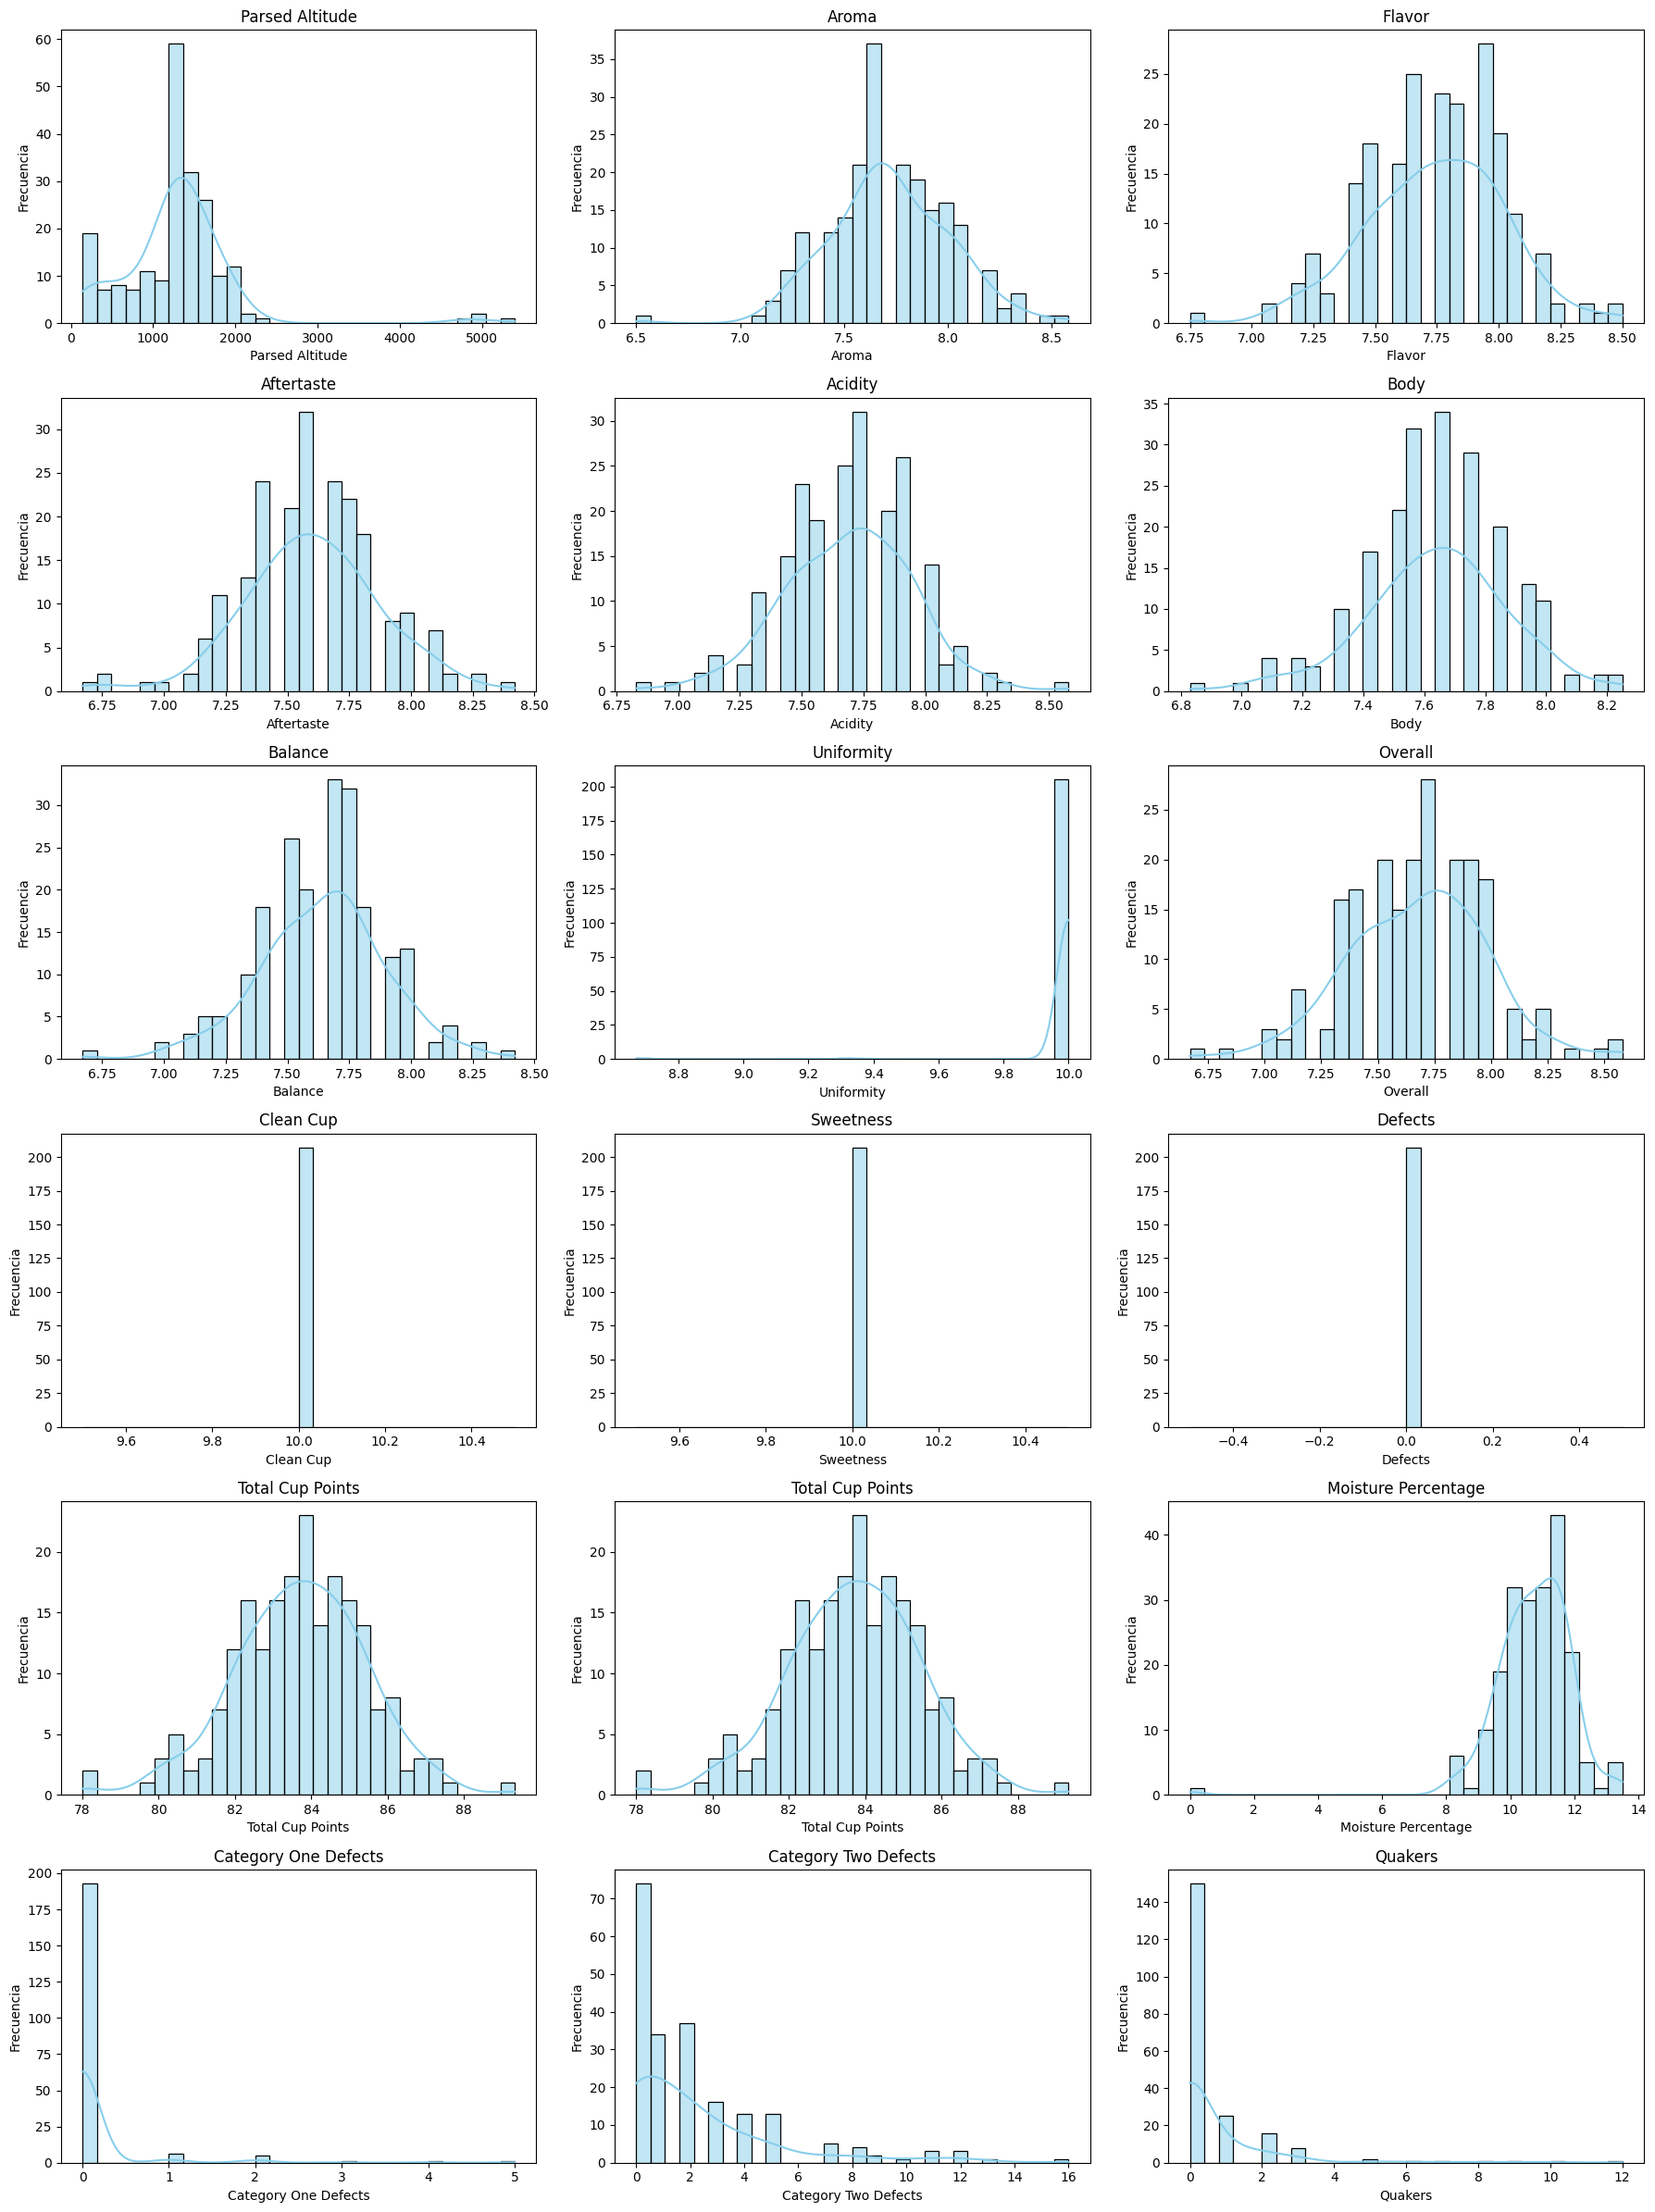

In [14]:
numeric_cols = ['Parsed Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', "Uniformity", 'Overall', "Clean Cup", "Sweetness", "Defects", "Total Cup Points", 'Total Cup Points', 'Moisture Percentage', 'Category One Defects', 'Category Two Defects', 'Quakers']

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
data["Uniformity"].value_counts()

Uniformity
10.00    205
9.33       1
8.67       1
Name: count, dtype: int64

In [16]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(["ID"])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_cols])

scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)
scaled_df

,Number of Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Overall,Defects,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects,Parsed Altitude
0,-0.633265,2.993534,2.707661,2.980060,3.436732,2.614819,3.034825,0.093753,0.0,0.0,2.955285,0.0,3.257632,0.855585,-0.229016,-0.410510,0.254427,0.581975
1,-0.633265,2.714721,2.707661,1.163485,1.196334,1.198113,2.369929,0.093753,0.0,0.0,2.693520,0.0,2.243864,-0.189052,-0.229016,-0.410510,-0.764924,-0.123080
2,-0.559462,2.122244,2.420858,1.744789,1.853003,1.198113,2.057037,0.093753,0.0,0.0,2.137270,0.0,2.151176,-0.269408,-0.229016,-0.410510,-0.085356,0.017931
3,-0.633265,1.250954,1.524596,2.071773,2.162023,2.271375,1.705034,0.093753,0.0,0.0,1.875506,0.0,2.006352,0.855585,-0.229016,-0.410510,-0.764924,0.863997
4,-0.629165,2.122244,2.098204,1.744789,2.162023,1.198113,1.079250,0.093753,0.0,0.0,1.875506,0.0,1.954216,0.694872,-0.229016,0.777959,-0.085356,0.793492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,8.546967,-1.920542,-2.060448,-2.469664,-2.009752,-0.948411,-1.854111,0.093753,0.0,0.0,-1.952802,0.0,-2.100859,0.534158,-0.229016,-0.410510,0.594211,-0.475607
203,0.592679,-1.362917,-2.383102,-3.087299,-2.009752,-0.948411,-1.854111,0.093753,0.0,0.0,-1.952802,0.0,-2.147202,-0.269408,-0.229016,0.777959,3.312481,-0.123080
204,0.768986,-1.641729,-2.060448,-1.888360,-2.666420,-2.408048,-2.206115,0.093753,0.0,0.0,-2.214567,0.0,-2.338370,0.694872,-0.229016,4.937598,2.972698,0.017931
205,-0.633265,-4.255600,-3.566167,-3.087299,-2.009752,-2.408048,-2.519006,0.093753,0.0,0.0,-2.770817,0.0,-3.259451,0.212732,-0.229016,6.720300,3.652265,-0.123080


c:\Program Files\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Program Files\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi

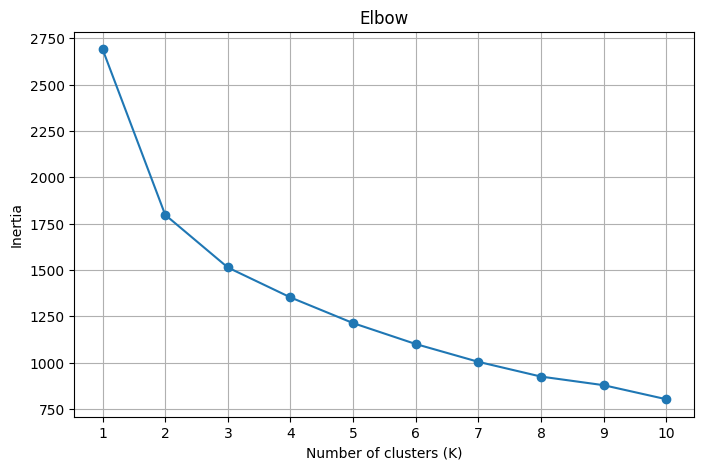

In [17]:
inertia = []
K = range(1, 11)  # probamos de 1 a 10 clusters
selected_columns = ['Parsed Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 
                   'Overall', 'Total Cup Points', 'Moisture Percentage', 
                   'Category One Defects', 'Category Two Defects', 'Quakers']
scaled_df = scaled_df[selected_columns]
# scaled_df = pd.concat([scaled_df, data[['ID']]], axis=1)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid(True)
plt.show()

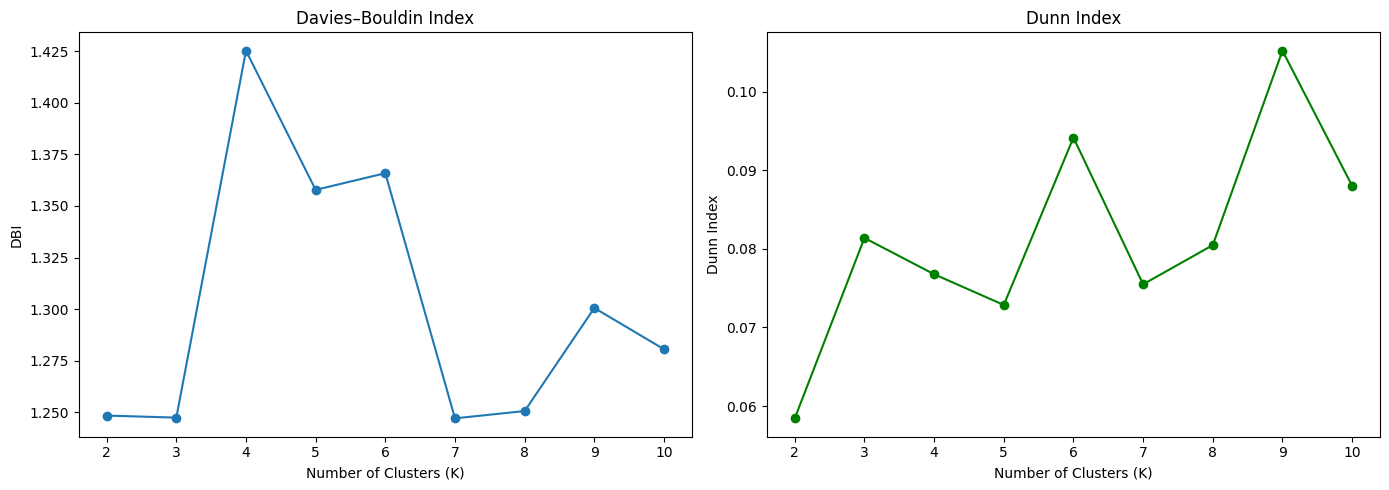


Resultados por cantidad de clusters (K):

K = 2: DBI = 1.248 | Dunn = 0.058
K = 3: DBI = 1.247 | Dunn = 0.081
K = 4: DBI = 1.425 | Dunn = 0.077
K = 5: DBI = 1.358 | Dunn = 0.073
K = 6: DBI = 1.366 | Dunn = 0.094
K = 7: DBI = 1.247 | Dunn = 0.075
K = 8: DBI = 1.251 | Dunn = 0.080
K = 9: DBI = 1.301 | Dunn = 0.105
K = 10: DBI = 1.281 | Dunn = 0.088


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Función para calcular el índice de Dunn
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for cluster in unique_clusters:
        points = X[labels == cluster]
        if len(points) > 1:
            intra_dists.append(np.max(cdist(points, points)))
        else:
            intra_dists.append(0)

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            points_i = X[labels == unique_clusters[i]]
            points_j = X[labels == unique_clusters[j]]
            inter_dists.append(np.min(cdist(points_i, points_j)))

    if len(inter_dists) == 0 or max(intra_dists) == 0:
        return 0
    return min(inter_dists) / max(intra_dists)

# Probar K de 2 a 10 (evitamos K=1 porque DBI y Dunn no están definidos para 1 cluster)
dbi_scores = []
dunn_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_df)
    dbi = davies_bouldin_score(scaled_df, labels)
    dunn = dunn_index(scaled_df.to_numpy(), labels)

    dbi_scores.append(dbi)
    dunn_scores.append(dunn)

# Graficar ambas métricas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, dbi_scores, marker='o')
axes[0].set_title('Davies–Bouldin Index')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('DBI')

axes[1].plot(K_range, dunn_scores, marker='o', color='green')
axes[1].set_title('Dunn Index')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Dunn Index')

plt.tight_layout()
plt.show()

print("\nResultados por cantidad de clusters (K):\n")
for k, dbi, dunn in zip(K_range, dbi_scores, dunn_scores):
    print(f"K = {k}: DBI = {dbi:.3f} | Dunn = {dunn:.3f}")

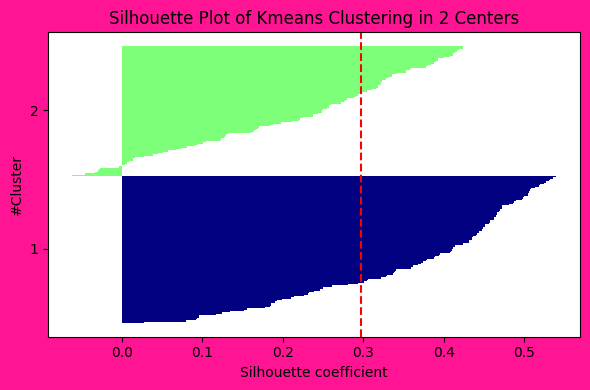

Silhouette Coefficient: 0.297


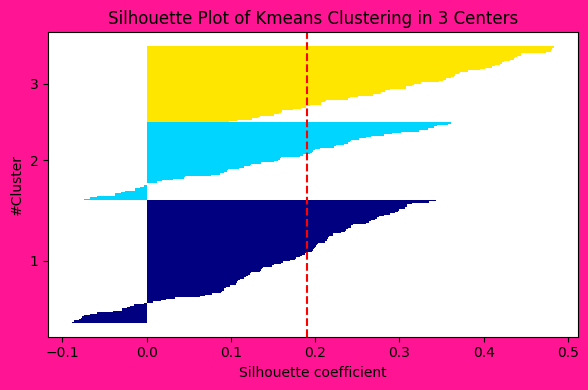

Silhouette Coefficient: 0.191


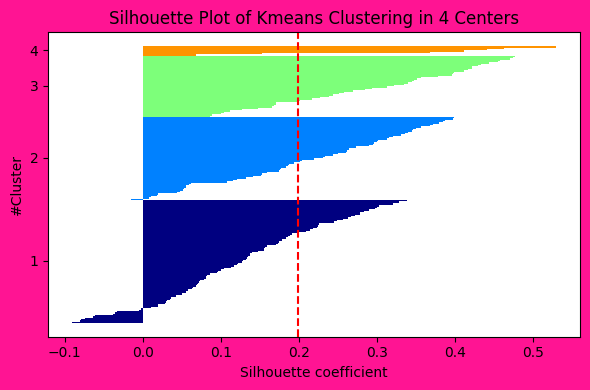

Silhouette Coefficient: 0.199


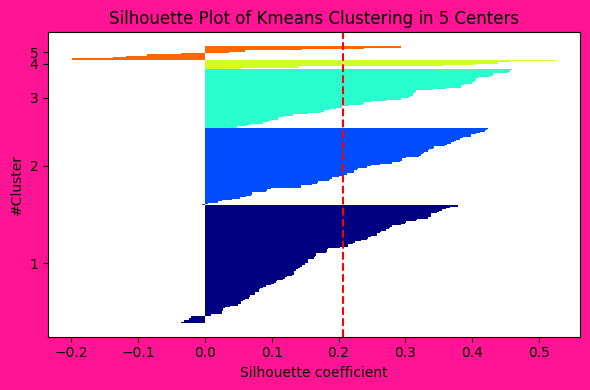

Silhouette Coefficient: 0.207


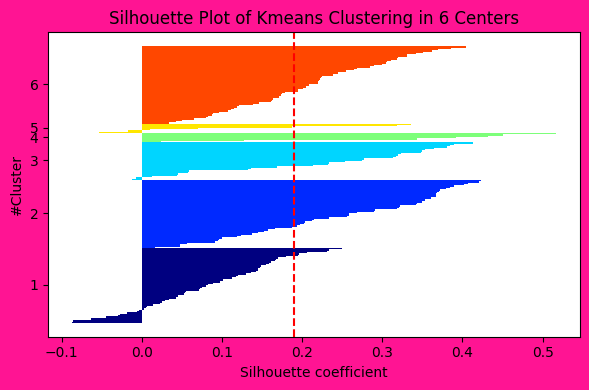

Silhouette Coefficient: 0.190


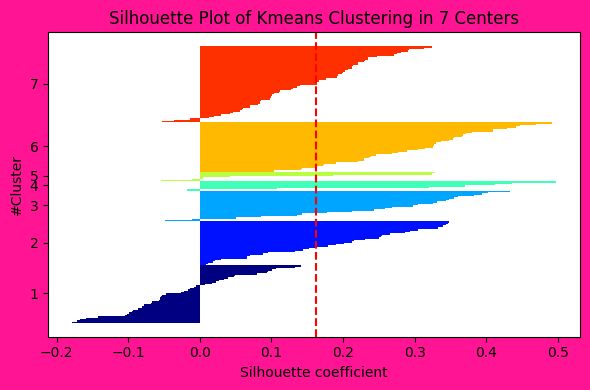

Silhouette Coefficient: 0.162


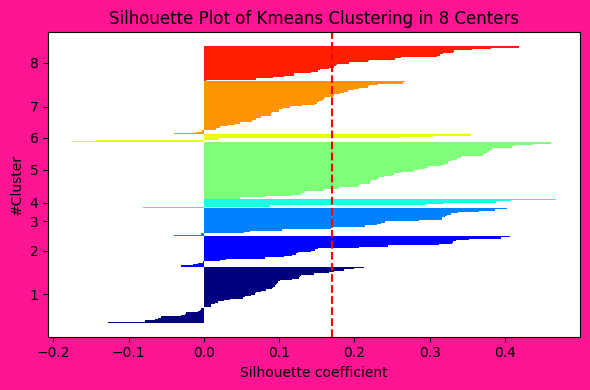

Silhouette Coefficient: 0.171


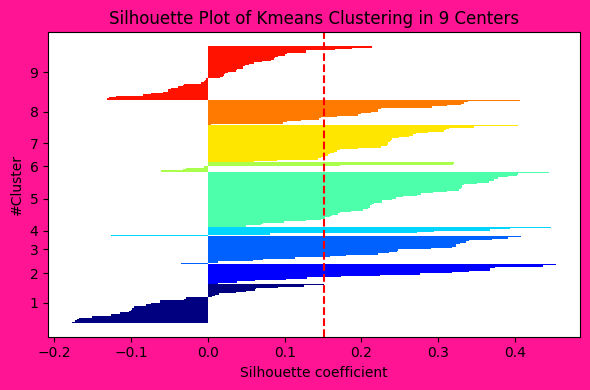

Silhouette Coefficient: 0.151


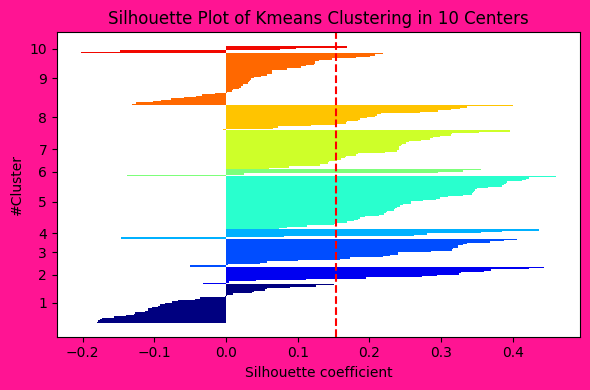

Silhouette Coefficient: 0.154


In [19]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

candidates = range(2, 11)
for k in candidates:
    km = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=300,
                tol=1e-04,
                random_state=42)

    clusters_pred = km.fit_predict(scaled_df)

    cluster_labels = np.unique(clusters_pred)
    n_clusters = cluster_labels.shape[0]

    #calculo
    silhouette_vals = silhouette_samples(scaled_df, clusters_pred, metric='euclidean')

    #grafico
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []


    plt.figure(figsize=(6,4),facecolor='deeppink')
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters_pred == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels + 1)
    plt.title(f'Silhouette Plot of Kmeans Clustering in {k} Centers')
    plt.ylabel('#Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.show()
    print("Silhouette Coefficient: %0.3f"
      % silhouette_score(scaled_df, clusters_pred, metric='euclidean'))

In [20]:
km = KMeans(n_clusters=3,
                init='k-means++',
                max_iter=300,
                tol=1e-04,
                random_state=42)

clusters_pred = km.fit_predict(scaled_df)
scaled_df['Cluster'] = clusters_pred

C:\Users\lukfi\AppData\Local\Temp\ipykernel_15208\386533643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df['Cluster'] = clusters_pred


In [21]:
scaled_df

,Parsed Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Category Two Defects,Quakers,Cluster
0,0.581975,2.993534,2.707661,2.980060,3.436732,2.614819,3.034825,2.955285,3.257632,0.855585,-0.229016,0.254427,-0.410510,2
1,-0.123080,2.714721,2.707661,1.163485,1.196334,1.198113,2.369929,2.693520,2.243864,-0.189052,-0.229016,-0.764924,-0.410510,2
2,0.017931,2.122244,2.420858,1.744789,1.853003,1.198113,2.057037,2.137270,2.151176,-0.269408,-0.229016,-0.085356,-0.410510,2
3,0.863997,1.250954,1.524596,2.071773,2.162023,2.271375,1.705034,1.875506,2.006352,0.855585,-0.229016,-0.764924,-0.410510,2
4,0.793492,2.122244,2.098204,1.744789,2.162023,1.198113,1.079250,1.875506,1.954216,0.694872,-0.229016,-0.085356,0.777959,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-0.475607,-1.920542,-2.060448,-2.469664,-2.009752,-0.948411,-1.854111,-1.952802,-2.100859,0.534158,-0.229016,0.594211,-0.410510,1
203,-0.123080,-1.362917,-2.383102,-3.087299,-2.009752,-0.948411,-1.854111,-1.952802,-2.147202,-0.269408,-0.229016,3.312481,0.777959,1
204,0.017931,-1.641729,-2.060448,-1.888360,-2.666420,-2.408048,-2.206115,-2.214567,-2.338370,0.694872,-0.229016,2.972698,4.937598,1
205,-0.123080,-4.255600,-3.566167,-3.087299,-2.009752,-2.408048,-2.519006,-2.770817,-3.259451,0.212732,-0.229016,3.652265,6.720300,1


In [22]:
scaled_df["Cluster"].value_counts()

Cluster
0    92
1    58
2    57
Name: count, dtype: int64

C:\Users\lukfi\AppData\Local\Temp\ipykernel_15208\527736063.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=target_column, data=scaled_df, palette={"0": 'red', "1": 'green', "2": 'blue'})


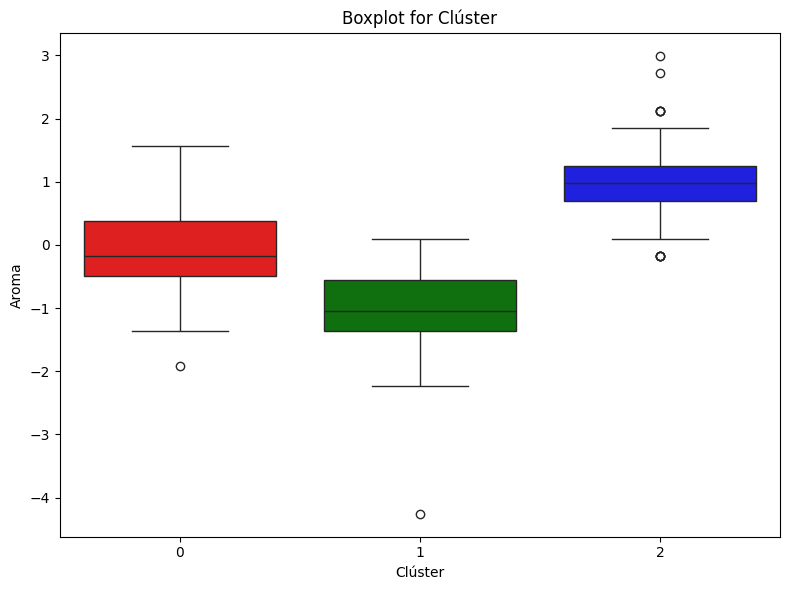

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurate de tener los datos en un DataFrame con una columna de clusters
# Por ejemplo: data["Cluster"] = clusters_pred
target_column_str = "Aroma"  # Nombre de la columna a graficar
# Columna numérica a graficar (puede cambiarse por el nombre real, ej: 'Parsed Altitude')
target_column = scaled_df[target_column_str]  # columna 8, según tu ejemplo

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y=target_column, data=scaled_df, palette={"0": 'red', "1": 'green', "2": 'blue'})

plt.title("Boxplot for Clúster")
plt.xlabel("Clúster")
plt.ylabel(target_column_str)
plt.tight_layout()
plt.show()